# DeePC Implementation

### Packages

In [1765]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel

%matplotlib inline
%reload_ext autoreload
%autoreload 

from DeePC import DeePC

## Recht system

In [1766]:
A = np.array([[1.01, 0.01, 0.00], # A - State-space matrix
              [0.01, 1.01, 0.01], 
              [0.00, 0.01, 1.01]]) 
B = np.eye(3) # B - State-space matrix
C = np.eye(3) # C - State-space matrix
D = np.zeros([3,3]) # D - State-space matrix

n = A.shape[0] # n = number of states
m = B.shape[1] # m = number of inputs
p = C.shape[0] # p = number of output
q = m+p # q = number of i/o variables

Tini = 4                                   # Past time horizon                                           
Tf = 10                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1                            


## Data Collection

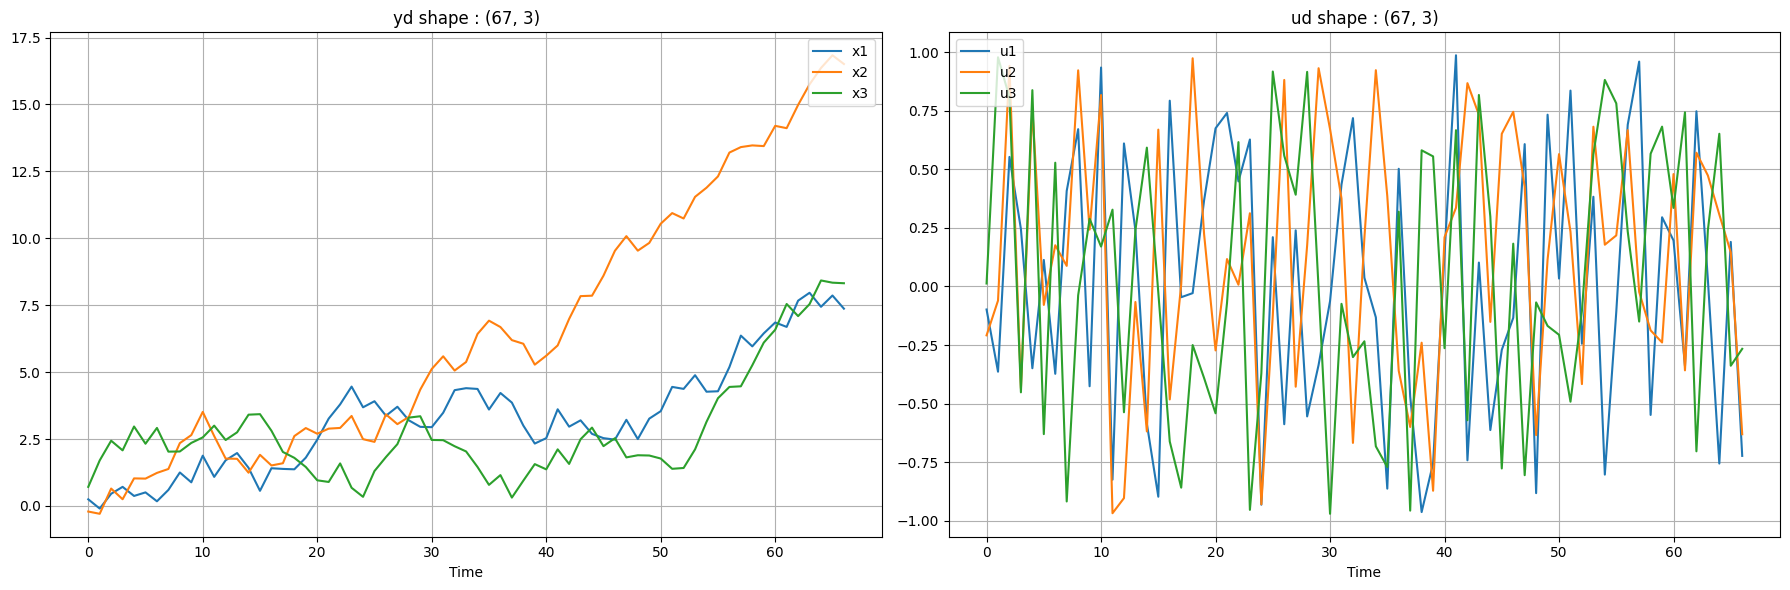

In [1767]:
ud = []
yd = []
x = np.random.uniform(low=-3, high=3, size=(m,))
for i in range(T):
   u = np.random.uniform(low=-1, high=1, size=(m,)) # Random input
   x = A@x + B@u
   y = C@x + D@u
   ud.append(u)
   yd.append(y+ np.random.randn(p,)*0.02)
ud = np.array(ud)
yd = np.array(yd)

# print(f'ud shape : {ud.shape}, yd shape : {yd.shape}')
plt.rcParams["figure.figsize"] = (18,6)
plt.subplot(1,2,1)
plt.plot(range(0,T), yd, label=['x1', 'x2', 'x3'])
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title(f"yd shape : {yd.shape}")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), ud, label=['u1', 'u2', 'u3'])
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.title(f"ud shape : {ud.shape}")
plt.grid('on')
plt.tight_layout()

plt.show()

ud = ud.reshape((T*m,))
yd = yd.reshape((T*p,))

## Solver Setup

In [1768]:
u_ini = ud[:m*Tini].reshape((Tini*m,))
y_ini = yd[:p*Tini].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([5,1,5]))
u_constraonts = np.kron(np.ones(Tf), np.array([5,5,5]))
R = np.eye(m)*0.1
Q = np.eye(p)*10
ref = np.array([-4,0,4])
r = np.kron(np.ones(Tf), ref)

controller = DeePC(
    ud=ud, yd=yd, y_constraints=y_constraints, u_constraints=u_constraonts,
    N=Tf, Tini=Tini, n=n, T=T, p=p, m=m, Q=Q, R=R
)
controller.setup(ref=r, u_ini=u_ini, y_ini=y_ini, lam_y=0.5)

## Simulation

In [1769]:
T = 25
uT = [*u_ini]
yT = [*y_ini]

for i in range(0,T):
    action = controller.solve(verbose=False)
    obs = A@y_ini[-p:] + action
    yT = np.append(yT, obs + np.random.randn(p,)*0.01)
    uT = np.append(uT, action)
    u_ini = uT[-m*Tini:]
    y_ini = yT[-p*Tini:]
    controller.setup(ref=r, u_ini=u_ini, y_ini=y_ini, lam_y=0.1)

## Visualisation

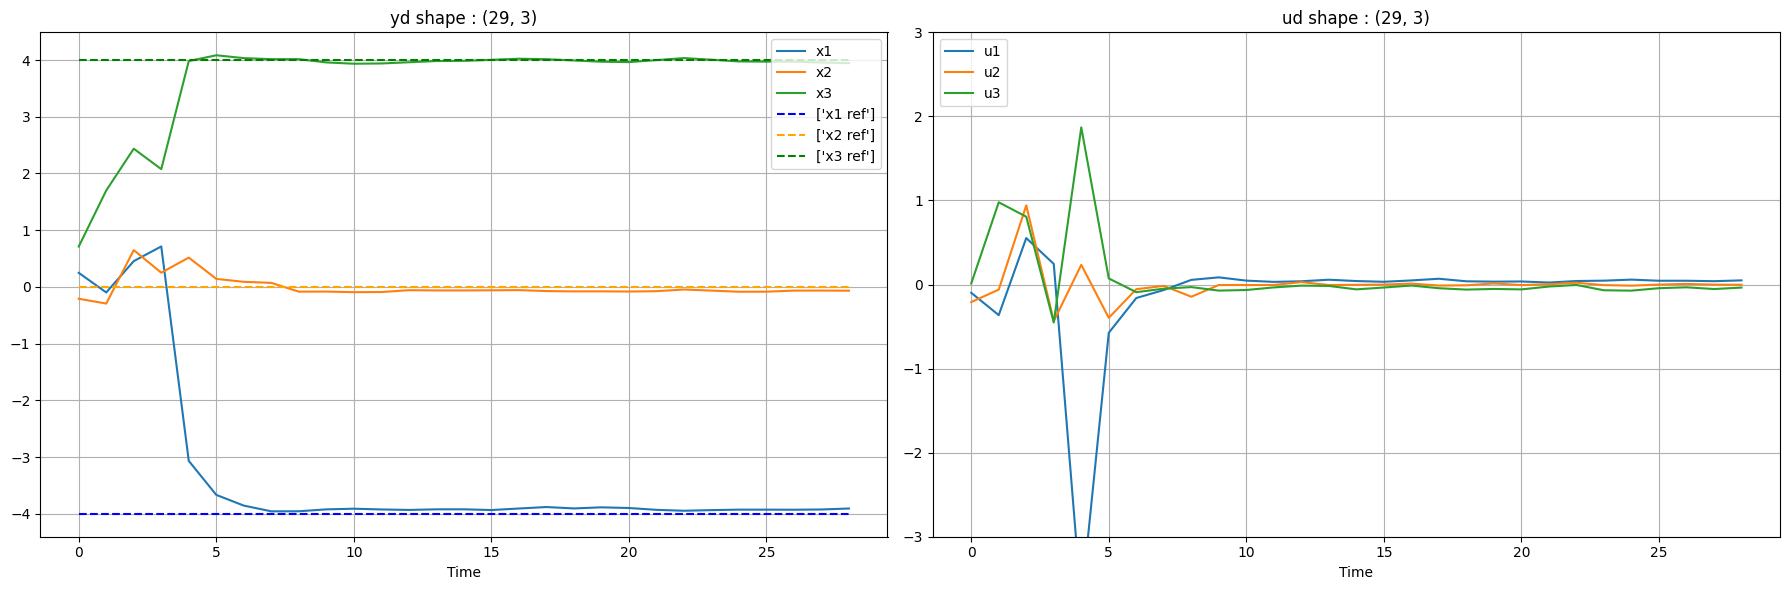

In [1770]:
plt.rcParams["figure.figsize"] = (18,6)
yT, uT = np.array(yT), np.array(uT)

yT = yT.reshape((T+Tini,3))
uT = uT.reshape((T+Tini,3))
plt.subplot(1,2,1)
plt.plot(range(0,T+Tini), yT, label=['x1', 'x2', 'x3'])
plt.plot(range(0,T+Tini), ref[0]*np.ones(T+Tini), 'b--',label=['x1 ref'])
plt.plot(range(0,T+Tini), ref[1]*np.zeros(T+Tini), '--', color='orange', label=['x2 ref'])
plt.plot(range(0,T+Tini), ref[2]*np.ones(T+Tini), 'g--', label=['x3 ref'])
# plt.plot(range(0,3), )
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title(f"yd shape : {yT.shape}")
plt.grid('on')
# plt.ylim(-10.5,10.5)
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T+Tini), uT, label=['u1', 'u2', 'u3'])
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.title(f"ud shape : {uT.shape}")
plt.grid('on')
plt.ylim(-3,3)
plt.tight_layout()

plt.show()